# VQR

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import time
import csv
from pathlib import Path

from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.algorithms.regressors import VQR
from qiskit_machine_learning.algorithms.classifiers import VQC

In [2]:
# Fixed values, three feature variables for this dataset
FEATURE_DIMENSION = 3

# Modifiable values
FEATURE_MAP_REPEATS = 2
ANSATZ_REPEATS = 2

In [3]:
def config_feature_map():
    feature_map = PauliFeatureMap(feature_dimension=FEATURE_DIMENSION, reps=FEATURE_MAP_REPEATS, entanglement='full')
    feature_map = ZZFeatureMap(feature_dimension=FEATURE_DIMENSION, reps=FEATURE_MAP_REPEATS, entanglement='full')

    # feature_map.decompose().draw(output="mpl", style="clifford", fold=20)
    return feature_map

In [4]:
def config_ansatz():
    ansatz = RealAmplitudes(num_qubits=FEATURE_DIMENSION, reps=ANSATZ_REPEATS)
    # ansatz.decompose().draw(output="mpl", style="clifford", fold=20)
    return ansatz

In [5]:
def config_optimizer():
    optimizer = L_BFGS_B(ftol=0.000001)
    return optimizer

In [6]:
def train_vqc(X_train, y_train, feature_map, ansatz, optimizer, objective_func_vals):

    def callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals.append(obj_func_eval)
        plt.rcParams["figure.figsize"] = (12, 6)
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals)
        plt.show()
        
    vqr = VQR(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph,
    )
        
    start = time.time()
    vqr.fit(X_train, y_train)
    elapsed = time.time() - start

    # plt.savefig(Path(message+"train.png"),dpi=300) # not gonna work
    
    print(f"Training time: {round(elapsed)} seconds")
    return vqr

In [7]:
def print_train_result(vqr, X_train, y_train):
    train_score = vqr.score(X_train, y_train)
    return train_score

In [8]:
def save_prediction_graph(y_scaler, vqr, element_test, X_test, y_test, date, i):
    y_hat = vqr.predict(X_test)
    y_test = y_scaler.inverse_transform(y_test)
    y_hat = y_scaler.inverse_transform(y_hat)
    plt.plot(element_test, y_scaler.inverse_transform(y_hat), 'o')
    plt.plot(element_test, y_scaler.inverse_transform(y_test), 'o')
    
    plt.xlabel("Element")
    plt.ylabel("SFE")
    plt.legend(["Predicted", "Actual"], bbox_to_anchor=(1, 0.9), loc='upper left')

    # plt.savefig(f'VQA/regression/figure/{date}/{date}_test_result_#{i}.png',dpi=300)
    plt.close

    return y_test, y_hat

In [9]:
def accuracy(y_test, y_hat):
    return r2_score(y_test, y_hat)

In [10]:
def prepare_dataset_k_fold(X, y, train_indices, test_indices):
    X_train_raw, X_test_raw = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    # Separate element column from the actual features
    element_test = X_test_raw[:, 0]
    
    # Drop the element column (first column)
    X_train = X_train_raw[:, 1:]
    X_test = X_test_raw[:, 1:]

    full_X = np.vstack([X_train, X_test])

    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaler = MaxAbsScaler()
    scaler = StandardScaler()
    scaler.fit(full_X)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test, element_test

In [23]:
def main_vqr(file_name, date):
    dataset_name = "qml_training-validation-data.csv"
    df = pd.read_csv(dataset_name)
    X = df[['Element', 'el_neg', 'B/GPa', 'Volume/A^3']].values
    y = df['SFE/mJm^-3'].values

    # y_scaler = MinMaxScaler(feature_range=(-1, 1))
    # y_scaler = MaxAbsScaler()
    y_scaler = StandardScaler()
    
    y = y_scaler.fit_transform(y.reshape(-1, 1))
    
    rkf = RepeatedKFold(n_splits=X.shape[0], n_repeats=3)

    df = pd.DataFrame(columns=['element test', 'actual', 'predicted'])

    i = 0

    feature_map = config_feature_map()
    ansatz = config_ansatz()
    optimizer = config_optimizer()
    
    for train_indices, test_indices in rkf.split(X):
        print(i)
        
        X_train, y_train, X_test, y_test, element_test = prepare_dataset_k_fold(X, y, train_indices, test_indices)
    
        
        objective_func_vals = []
        vqr = train_vqc(X_train, y_train, feature_map, ansatz, optimizer, objective_func_vals)
        y_test, y_hat = save_prediction_graph(y_scaler, vqr, element_test, X_test, y_test, date, i)
        
        new_row = {'element test': element_test,
                   'actual': np.array(y_test).flatten(),
                   'predicted': np.array(y_hat).flatten()}
        df.loc[len(df)] = new_row
        
        i += 1
        
    df.at[0, "info"] = [f"DATASET: {dataset_name}, SCALER = {y_scaler.__dict__}, FEATURE_MAP = {feature_map.__dict__}, ANSATZ_REPS = {ansatz.__dict__}, OPTIMIZER: {optimizer.__dict__}"]
    df.to_csv(file_name, index=False) 

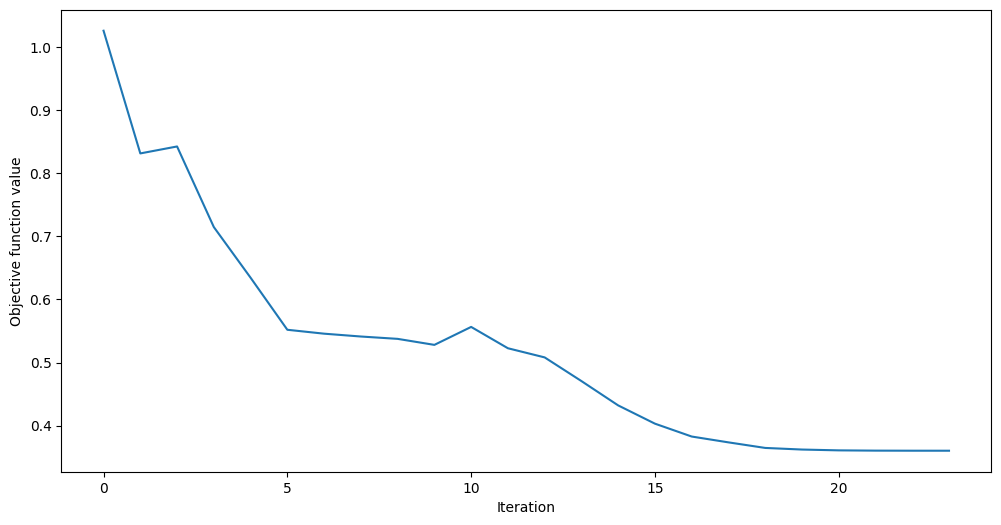

In [ ]:
date = '05_27_25_2'
path = 'VQA/regression'
! mkdir $path/figure/$date
filename = f'{date}.csv'
file_dir = f'{path}/result/{filename}'
main_vqr(file_dir, date)

# VQC

In [11]:
def process(y):
    for i in range(0,len(y)): 
        if y[i]>19: y[i]=0
        else: y[i]=1
    return y

In [12]:
def train_vqc(X_train, y_train, feature_map, ansatz, optimizer, objective_func_vals):

    def callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals.append(obj_func_eval)
        plt.rcParams["figure.figsize"] = (12, 6)
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals)
        plt.show()
        
    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        loss="cross_entropy",
        optimizer=optimizer,
        callback=callback_graph,
    )
        
    start = time.time()
    vqc.fit(X_train, y_train)
    elapsed = time.time() - start

    # plt.savefig(Path(message+"train.png"),dpi=300) # not gonna work
    
    print(f"Training time: {round(elapsed)} seconds")
    return vqc

In [18]:
def main_vqc(file_name, date):
    dataset_name = "qml_training-validation-data.csv"
    df = pd.read_csv(dataset_name)
    X = df[['Element', 'el_neg', 'B/GPa', 'Volume/A^3']].values
    y = df['SFE/mJm^-3'].values
    
    y = process(y)
    
    rkf = RepeatedKFold(n_splits=X.shape[0], n_repeats=3)

    df = pd.DataFrame(columns=['element test', 'actual', 'predicted'])

    i = 0

    feature_map = config_feature_map()
    ansatz = config_ansatz()
    optimizer = config_optimizer()
    
    for train_indices, test_indices in rkf.split(X):
        print(i)
        
        X_train, y_train, X_test, y_test, element_test = prepare_dataset_k_fold(X, y, train_indices, test_indices)
    
        
        objective_func_vals = []
        vqc = train_vqc(X_train, y_train, feature_map, ansatz, optimizer, objective_func_vals)
        y_hat = vqc.predict(X_test)
        
        new_row = {'element test': element_test,
                   'actual': np.array(y_test).flatten(),
                   'predicted': np.array(y_hat).flatten()}
        df.loc[len(df)] = new_row
        
        i += 1
        
    df.at[0, "info"] = [f"DATASET: {dataset_name}, FEATURE_MAP = {feature_map.__dict__}, ANSATZ_REPS = {ansatz.__dict__}, OPTIMIZER: {optimizer.__dict__}"]
    df.to_csv(file_name, index=False) 

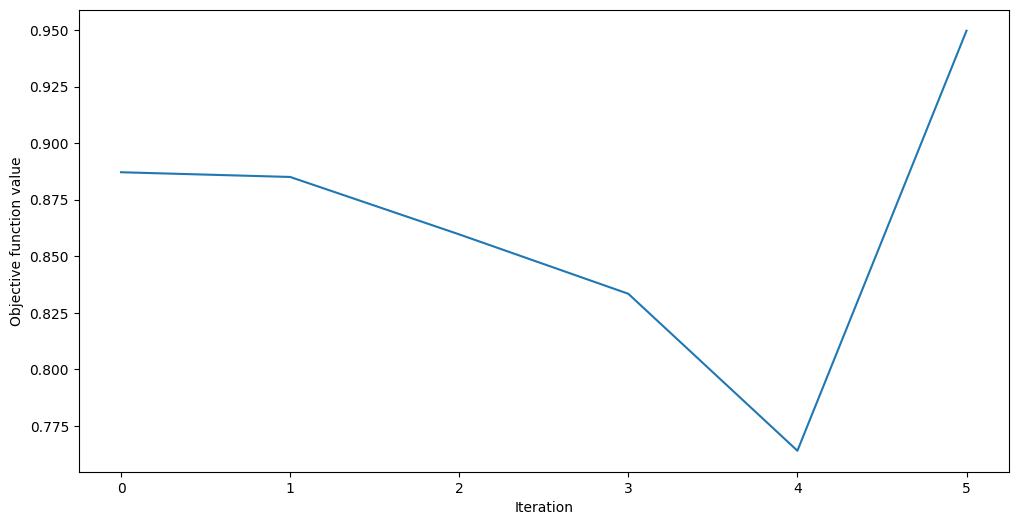

In [ ]:
date = '05_27_25_0'
path = 'VQA/classification'
! mkdir $path/figure/$date
filename = f'{date}.csv'
file_dir = f'{path}/result/{filename}'
main_vqc(file_dir, date)